# Customer Churn Analytics: Predictive Business Intelligence

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Set aesthetic style
sns.set(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (10, 6)

## Data Loading & Cleaning

In [2]:
# Load Data
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Convert TotalCharges to numeric (handling empty strings)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

# Copy for manipulation
data = df.copy()

print(f"Dataset Shape: {data.shape}")
data.head()

Dataset Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Feature Engineering

In [3]:
# Simulate Signup Date from Tenure
snapshot_date = datetime(2024, 1, 1)
data['SignupDate'] = data['tenure'].apply(lambda x: snapshot_date - timedelta(days=x*30))
data['CohortMonth'] = data['SignupDate'].dt.to_period('M')

# Create Plan Tiers (Basic, Pro, Enterprise) based on MonthlyCharges
def assign_plan_tier(charge):
    if charge < 50:
        return 'Basic'
    elif charge < 80:
        return 'Pro'
    else:
        return 'Enterprise'

data['PlanTier'] = data['MonthlyCharges'].apply(assign_plan_tier)

# Encode Plan Tiers
le_plan = LabelEncoder()
data['PlanTierEncoded'] = le_plan.fit_transform(data['PlanTier'])

# Normalize Usage Metrics
scaler_features = StandardScaler()
data[['tenure_scaled', 'MonthlyCharges_scaled', 'TotalCharges_scaled']] = scaler_features.fit_transform(
    data[['tenure', 'MonthlyCharges', 'TotalCharges']]
)

# Create Churn Binary
data['ChurnBinary'] = data['Churn'].map({'Yes': 1, 'No': 0})

print("Feature Engineering Complete")
data[['customerID', 'tenure', 'PlanTier', 'ChurnBinary']].head()

Feature Engineering Complete


,customerID,tenure,PlanTier,ChurnBinary
0,7590-VHVEG,1,Basic,0
1,5575-GNVDE,34,Pro,0
2,3668-QPYBK,2,Pro,1
3,7795-CFOCW,45,Basic,0
4,9237-HQITU,2,Pro,1


## KPI Dashboard

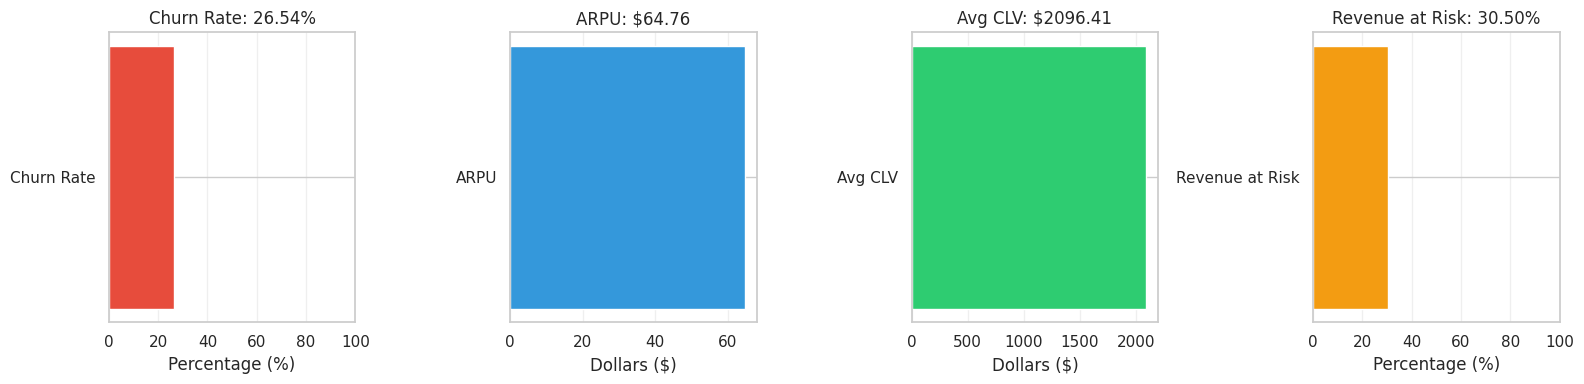

Churn Rate: 26.54%
ARPU: $64.76
Avg CLV: $2096.41
Revenue at Risk: 30.50%


In [4]:
# Calculate KPIs
churn_rate = (data[data['Churn'] == 'Yes'].shape[0] / data.shape[0]) * 100
arpu = data['MonthlyCharges'].mean()
simple_clv = data['MonthlyCharges'].mean() * data['tenure'].mean()

# Revenue at Risk (from churned customers)
churned_revenue = data[data['Churn'] == 'Yes']['MonthlyCharges'].sum()
total_revenue = data['MonthlyCharges'].sum()
revenue_at_risk_pct = (churned_revenue / total_revenue) * 100

# Visualize KPIs
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Churn Rate
axes[0].barh(['Churn Rate'], [churn_rate], color='#e74c3c')
axes[0].set_xlim(0, 100)
axes[0].set_xlabel('Percentage (%)')
axes[0].set_title(f'Churn Rate: {churn_rate:.2f}%')
axes[0].grid(axis='x', alpha=0.3)

# ARPU
axes[1].barh(['ARPU'], [arpu], color='#3498db')
axes[1].set_xlabel('Dollars ($)')
axes[1].set_title(f'ARPU: ${arpu:.2f}')
axes[1].grid(axis='x', alpha=0.3)

# CLV
axes[2].barh(['Avg CLV'], [simple_clv], color='#2ecc71')
axes[2].set_xlabel('Dollars ($)')
axes[2].set_title(f'Avg CLV: ${simple_clv:.2f}')
axes[2].grid(axis='x', alpha=0.3)

# Revenue at Risk
axes[3].barh(['Revenue at Risk'], [revenue_at_risk_pct], color='#f39c12')
axes[3].set_xlim(0, 100)
axes[3].set_xlabel('Percentage (%)')
axes[3].set_title(f'Revenue at Risk: {revenue_at_risk_pct:.2f}%')
axes[3].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Churn Rate: {churn_rate:.2f}%")
print(f"ARPU: ${arpu:.2f}")
print(f"Avg CLV: ${simple_clv:.2f}")
print(f"Revenue at Risk: {revenue_at_risk_pct:.2f}%")

## Cohort Analysis: Retention Heatmap

In [5]:
# Create Cohort Retention Matrix (for potential future analysis)
cohorts = data.groupby('CohortMonth').agg({
    'customerID': 'count',
    'ChurnBinary': lambda x: (x == 0).sum()  # Retained customers
}).rename(columns={'customerID': 'TotalCustomers', 'ChurnBinary': 'Retained'})

# Calculate retention rate by cohort
cohorts['RetentionRate'] = (cohorts['Retained'] / cohorts['TotalCustomers']) * 100
cohorts = cohorts.sort_index()

print("Cohort analysis data prepared.")

Cohort analysis data prepared.


## Feature Usage vs Churn: Correlation Analysis

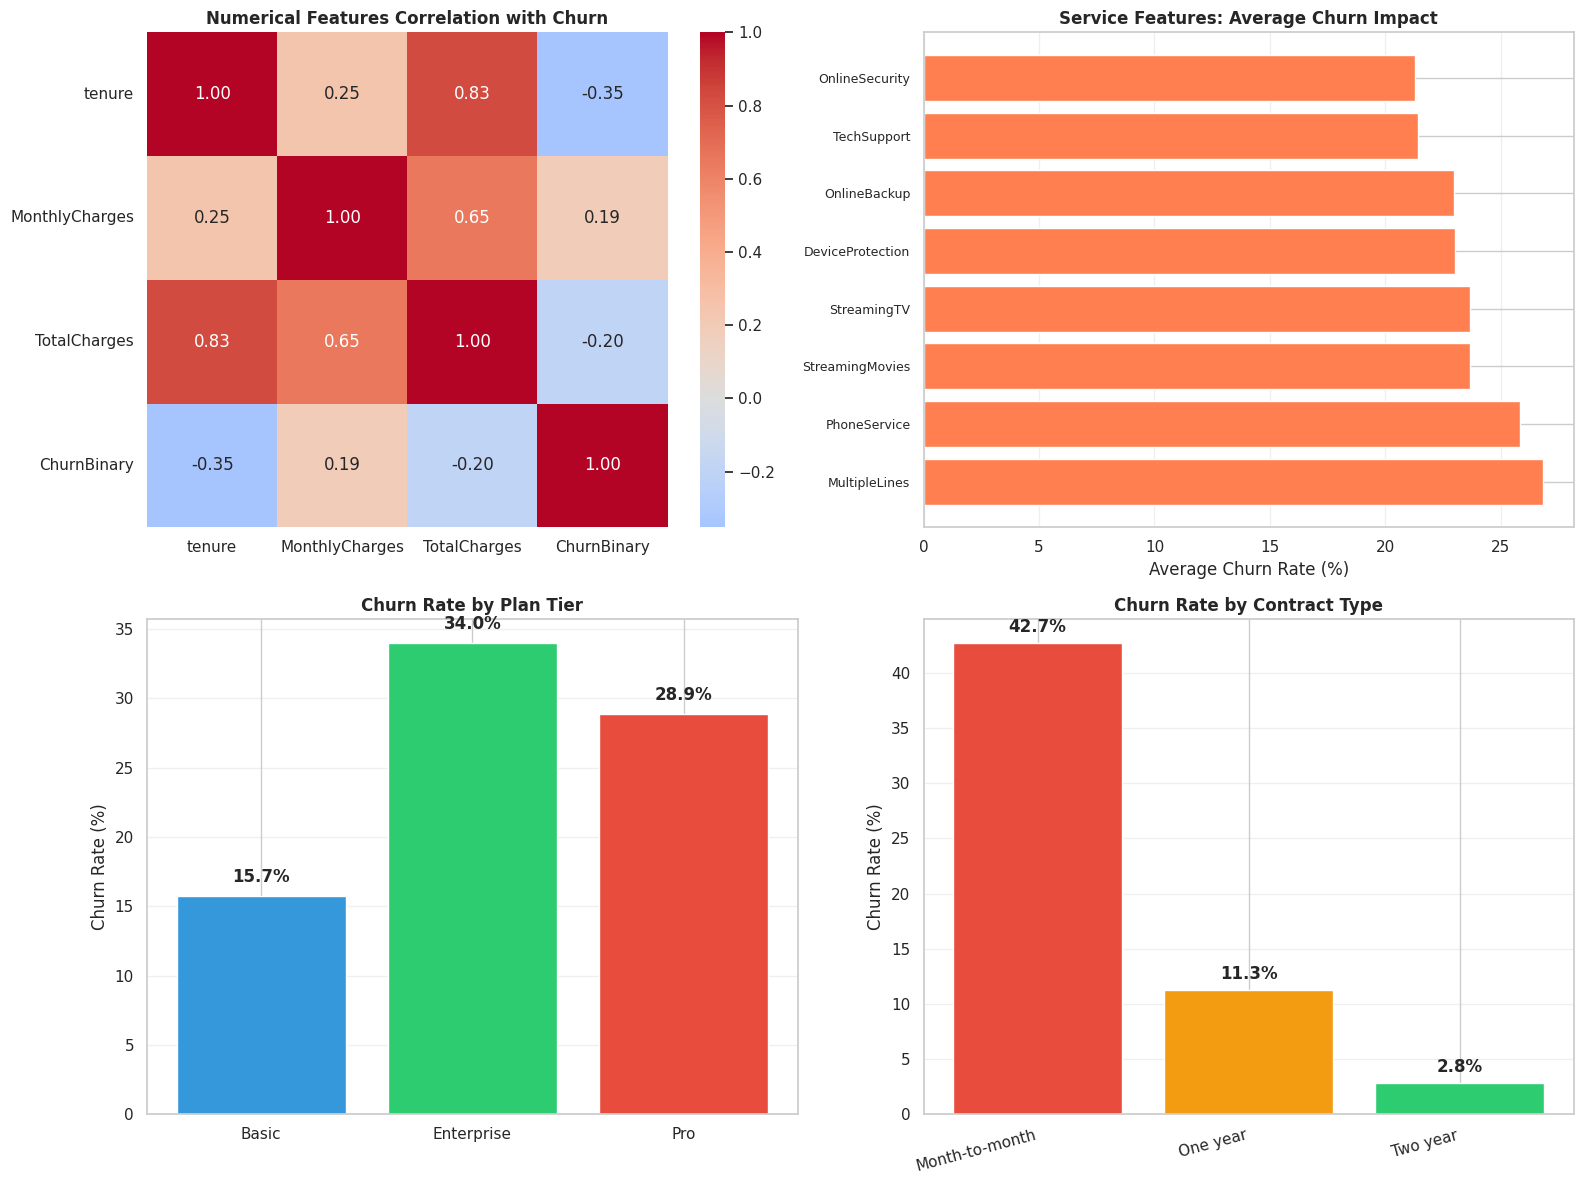

In [6]:
# Feature Usage Analysis: Service Adoption vs Churn
service_features = ['PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
                    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

service_churn_data = []
for service in service_features:
    for value in data[service].unique():
        if pd.notna(value) and value != 'No phone service':
            subset = data[data[service] == value]
            churn_pct = (subset['ChurnBinary'].sum() / len(subset)) * 100
            service_churn_data.append({
                'Service': service,
                'Value': value,
                'ChurnRate': churn_pct,
                'Count': len(subset)
            })

service_df = pd.DataFrame(service_churn_data)

# Visualize Service Usage Impact on Churn
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Correlation Heatmap
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'ChurnBinary']
corr = data[numerical_features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", center=0, ax=axes[0,0])
axes[0,0].set_title('Numerical Features Correlation with Churn', fontweight='bold')

# 2. Service Adoption vs Churn Rate
service_summary = service_df.groupby('Service')['ChurnRate'].mean().sort_values(ascending=False)
axes[0,1].barh(range(len(service_summary)), service_summary.values, color='coral')
axes[0,1].set_yticks(range(len(service_summary)))
axes[0,1].set_yticklabels(service_summary.index, fontsize=9)
axes[0,1].set_xlabel('Average Churn Rate (%)')
axes[0,1].set_title('Service Features: Average Churn Impact', fontweight='bold')
axes[0,1].grid(axis='x', alpha=0.3)

# 3. Plan Tier vs Churn
plan_churn = data.groupby('PlanTier')['ChurnBinary'].agg(['mean', 'count'])
plan_churn['ChurnRate'] = plan_churn['mean'] * 100
axes[1,0].bar(plan_churn.index, plan_churn['ChurnRate'], color=['#3498db', '#2ecc71', '#e74c3c'])
axes[1,0].set_ylabel('Churn Rate (%)')
axes[1,0].set_title('Churn Rate by Plan Tier', fontweight='bold')
axes[1,0].grid(axis='y', alpha=0.3)
for i, (idx, row) in enumerate(plan_churn.iterrows()):
    axes[1,0].text(i, row['ChurnRate'] + 1, f"{row['ChurnRate']:.1f}%", ha='center', fontweight='bold')

# 4. Contract Type vs Churn
contract_churn = data.groupby('Contract')['ChurnBinary'].agg(['mean', 'count'])
contract_churn['ChurnRate'] = contract_churn['mean'] * 100
axes[1,1].bar(range(len(contract_churn)), contract_churn['ChurnRate'],
              color=['#e74c3c', '#f39c12', '#2ecc71'])
axes[1,1].set_xticks(range(len(contract_churn)))
axes[1,1].set_xticklabels(contract_churn.index, rotation=15, ha='right')
axes[1,1].set_ylabel('Churn Rate (%)')
axes[1,1].set_title('Churn Rate by Contract Type', fontweight='bold')
axes[1,1].grid(axis='y', alpha=0.3)
for i, (idx, row) in enumerate(contract_churn.iterrows()):
    axes[1,1].text(i, row['ChurnRate'] + 1, f"{row['ChurnRate']:.1f}%", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

## Additional Business Analytics Visualizations

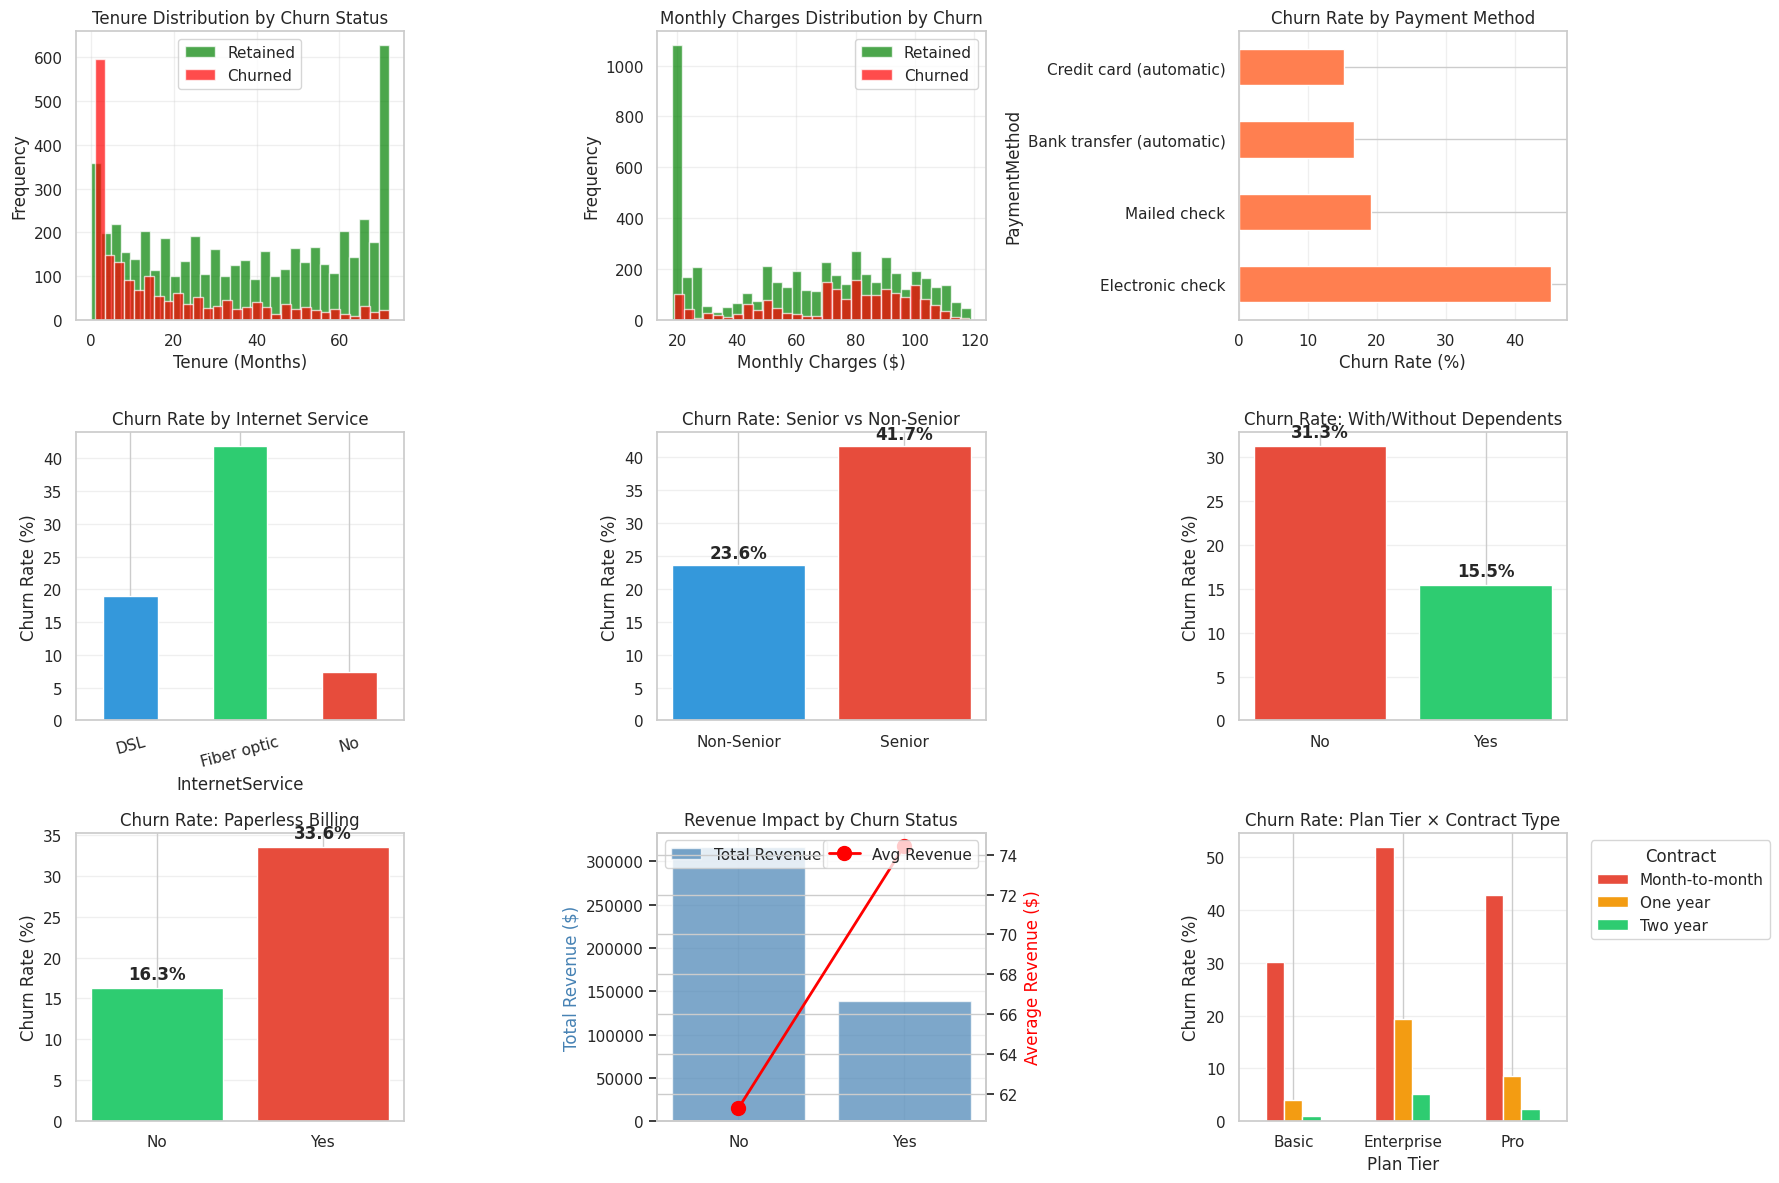

In [7]:
# Create comprehensive business analytics visualizations
fig = plt.figure(figsize=(18, 12))

# 1. Tenure Distribution by Churn Status
ax1 = plt.subplot(3, 3, 1)
data[data['Churn'] == 'No']['tenure'].hist(bins=30, alpha=0.7, label='Retained', color='green', ax=ax1)
data[data['Churn'] == 'Yes']['tenure'].hist(bins=30, alpha=0.7, label='Churned', color='red', ax=ax1)
ax1.set_xlabel('Tenure (Months)')
ax1.set_ylabel('Frequency')
ax1.set_title('Tenure Distribution by Churn Status')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Monthly Charges Distribution by Churn
ax2 = plt.subplot(3, 3, 2)
data[data['Churn'] == 'No']['MonthlyCharges'].hist(bins=30, alpha=0.7, label='Retained', color='green', ax=ax2)
data[data['Churn'] == 'Yes']['MonthlyCharges'].hist(bins=30, alpha=0.7, label='Churned', color='red', ax=ax2)
ax2.set_xlabel('Monthly Charges ($)')
ax2.set_ylabel('Frequency')
ax2.set_title('Monthly Charges Distribution by Churn')
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Payment Method Impact
ax3 = plt.subplot(3, 3, 3)
payment_churn = data.groupby('PaymentMethod')['ChurnBinary'].mean() * 100
payment_churn.sort_values(ascending=False).plot(kind='barh', ax=ax3, color='coral')
ax3.set_xlabel('Churn Rate (%)')
ax3.set_title('Churn Rate by Payment Method')
ax3.grid(axis='x', alpha=0.3)

# 4. Internet Service Type Impact
ax4 = plt.subplot(3, 3, 4)
internet_churn = data.groupby('InternetService')['ChurnBinary'].mean() * 100
internet_churn.plot(kind='bar', ax=ax4, color=['#3498db', '#2ecc71', '#e74c3c'])
ax4.set_ylabel('Churn Rate (%)')
ax4.set_title('Churn Rate by Internet Service')
ax4.grid(axis='y', alpha=0.3)
ax4.tick_params(axis='x', rotation=15)

# 5. Senior Citizen Analysis
ax5 = plt.subplot(3, 3, 5)
senior_churn = data.groupby('SeniorCitizen')['ChurnBinary'].mean() * 100
senior_labels = ['Non-Senior', 'Senior']
ax5.bar(senior_labels, senior_churn.values, color=['#3498db', '#e74c3c'])
ax5.set_ylabel('Churn Rate (%)')
ax5.set_title('Churn Rate: Senior vs Non-Senior')
ax5.grid(axis='y', alpha=0.3)
for i, v in enumerate(senior_churn.values):
    ax5.text(i, v + 1, f"{v:.1f}%", ha='center', fontweight='bold')

# 6. Dependents Impact
ax6 = plt.subplot(3, 3, 6)
dependents_churn = data.groupby('Dependents')['ChurnBinary'].mean() * 100
ax6.bar(dependents_churn.index, dependents_churn.values, color=['#e74c3c', '#2ecc71'])
ax6.set_ylabel('Churn Rate (%)')
ax6.set_title('Churn Rate: With/Without Dependents')
ax6.grid(axis='y', alpha=0.3)
for i, (idx, val) in enumerate(dependents_churn.items()):
    ax6.text(i, val + 1, f"{val:.1f}%", ha='center', fontweight='bold')

# 7. Paperless Billing Impact
ax7 = plt.subplot(3, 3, 7)
paperless_churn = data.groupby('PaperlessBilling')['ChurnBinary'].mean() * 100
ax7.bar(paperless_churn.index, paperless_churn.values, color=['#2ecc71', '#e74c3c'])
ax7.set_ylabel('Churn Rate (%)')
ax7.set_title('Churn Rate: Paperless Billing')
ax7.grid(axis='y', alpha=0.3)
for i, (idx, val) in enumerate(paperless_churn.items()):
    ax7.text(i, val + 1, f"{val:.1f}%", ha='center', fontweight='bold')

# 8. Revenue Impact Analysis
ax8 = plt.subplot(3, 3, 8)
revenue_by_churn = data.groupby('Churn')['MonthlyCharges'].agg(['sum', 'mean', 'count'])
revenue_by_churn['TotalRevenue'] = revenue_by_churn['sum']
revenue_by_churn['AvgRevenue'] = revenue_by_churn['mean']
ax8_twin = ax8.twinx()
x_pos = range(len(revenue_by_churn))
ax8.bar(x_pos, revenue_by_churn['TotalRevenue'], alpha=0.7, color='steelblue', label='Total Revenue')
ax8_twin.plot(x_pos, revenue_by_churn['AvgRevenue'], marker='o', color='red', linewidth=2, markersize=10, label='Avg Revenue')
ax8.set_xticks(x_pos)
ax8.set_xticklabels(revenue_by_churn.index)
ax8.set_ylabel('Total Revenue ($)', color='steelblue')
ax8_twin.set_ylabel('Average Revenue ($)', color='red')
ax8.set_title('Revenue Impact by Churn Status')
ax8.legend(loc='upper left')
ax8_twin.legend(loc='upper right')
ax8.grid(alpha=0.3)

# 9. Customer Segmentation: Plan Tier vs Contract
ax9 = plt.subplot(3, 3, 9)
segmentation = data.groupby(['PlanTier', 'Contract'])['ChurnBinary'].mean().unstack() * 100
segmentation.plot(kind='bar', ax=ax9, color=['#e74c3c', '#f39c12', '#2ecc71'])
ax9.set_ylabel('Churn Rate (%)')
ax9.set_title('Churn Rate: Plan Tier × Contract Type')
ax9.set_xlabel('Plan Tier')
ax9.legend(title='Contract', bbox_to_anchor=(1.05, 1), loc='upper left')
ax9.grid(axis='y', alpha=0.3)
ax9.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

## Predictive Analytics: Churn Risk Score

=== MODEL PERFORMANCE ===
Accuracy: 0.8233

Classification Report:
              precision    recall  f1-score   support

    Retained       0.86      0.90      0.88      1036
     Churned       0.69      0.60      0.64       373

    accuracy                           0.82      1409
   macro avg       0.78      0.75      0.76      1409
weighted avg       0.82      0.82      0.82      1409



/tmp/ipython-input-1319291358.py:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk_by_segment = data.groupby(['RiskCategory', 'PlanTier']).size().unstack(fill_value=0)


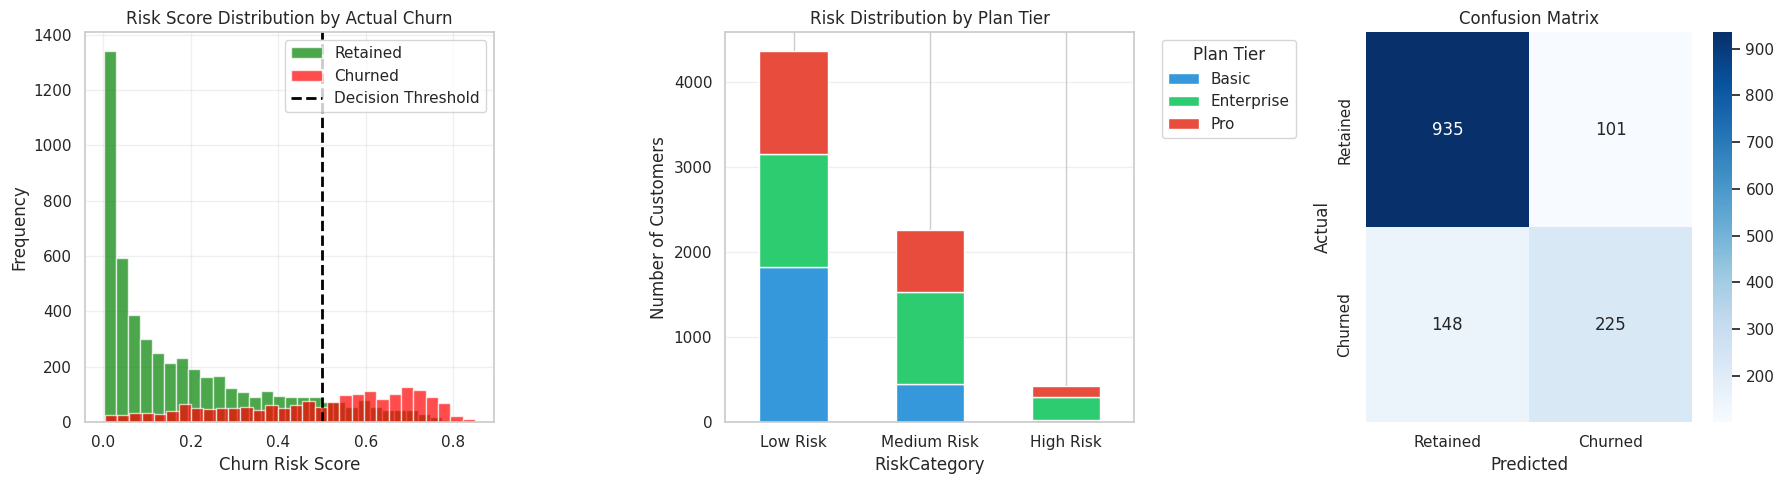


High-Risk Customers (Risk Score > 0.7): 427
Medium-Risk Customers (0.3 < Risk Score <= 0.7): 2256
Low-Risk Customers (Risk Score <= 0.3): 4360


In [8]:
# Preprocessing for Model
cat_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService',
            'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
            'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'PlanTier']

# One-Hot Encoding
data_model = pd.get_dummies(data, columns=cat_cols, drop_first=True)

# Features & Target
X = data_model.drop(['customerID', 'Churn', 'ChurnBinary', 'SignupDate', 'CohortMonth',
                     'tenure_scaled', 'MonthlyCharges_scaled', 'TotalCharges_scaled', 'PlanTierEncoded'], axis=1, errors='ignore')
y = data_model['ChurnBinary']

# Scale Numerical Cols
scaler = StandardScaler()
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
X[num_cols] = scaler.fit_transform(X[num_cols])

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Evaluate
y_pred = log_reg.predict(X_test)
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]

print("=== MODEL PERFORMANCE ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Retained', 'Churned']))

# Assign Risk Score to all customers
data['ChurnRiskScore'] = log_reg.predict_proba(X)[:, 1]

# Visualize Risk Score Distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Risk Score Distribution
axes[0].hist(data[data['Churn'] == 'No']['ChurnRiskScore'], bins=30, alpha=0.7, label='Retained', color='green')
axes[0].hist(data[data['Churn'] == 'Yes']['ChurnRiskScore'], bins=30, alpha=0.7, label='Churned', color='red')
axes[0].axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Decision Threshold')
axes[0].set_xlabel('Churn Risk Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Risk Score Distribution by Actual Churn')
axes[0].legend()
axes[0].grid(alpha=0.3)

# High-Risk Customers by Segment
data['RiskCategory'] = pd.cut(data['ChurnRiskScore'],
                               bins=[0, 0.3, 0.7, 1.0],
                               labels=['Low Risk', 'Medium Risk', 'High Risk'])
risk_by_segment = data.groupby(['RiskCategory', 'PlanTier']).size().unstack(fill_value=0)
risk_by_segment.plot(kind='bar', stacked=True, ax=axes[1], color=['#3498db', '#2ecc71', '#e74c3c'])
axes[1].set_ylabel('Number of Customers')
axes[1].set_title('Risk Distribution by Plan Tier')
axes[1].legend(title='Plan Tier', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].tick_params(axis='x', rotation=0)
axes[1].grid(axis='y', alpha=0.3)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[2],
            xticklabels=['Retained', 'Churned'], yticklabels=['Retained', 'Churned'])
axes[2].set_ylabel('Actual')
axes[2].set_xlabel('Predicted')
axes[2].set_title('Confusion Matrix')

plt.tight_layout()
plt.show()

print(f"\nHigh-Risk Customers (Risk Score > 0.7): {len(data[data['ChurnRiskScore'] > 0.7])}")
print(f"Medium-Risk Customers (0.3 < Risk Score <= 0.7): {len(data[(data['ChurnRiskScore'] > 0.3) & (data['ChurnRiskScore'] <= 0.7)])}")
print(f"Low-Risk Customers (Risk Score <= 0.3): {len(data[data['ChurnRiskScore'] <= 0.3])}")

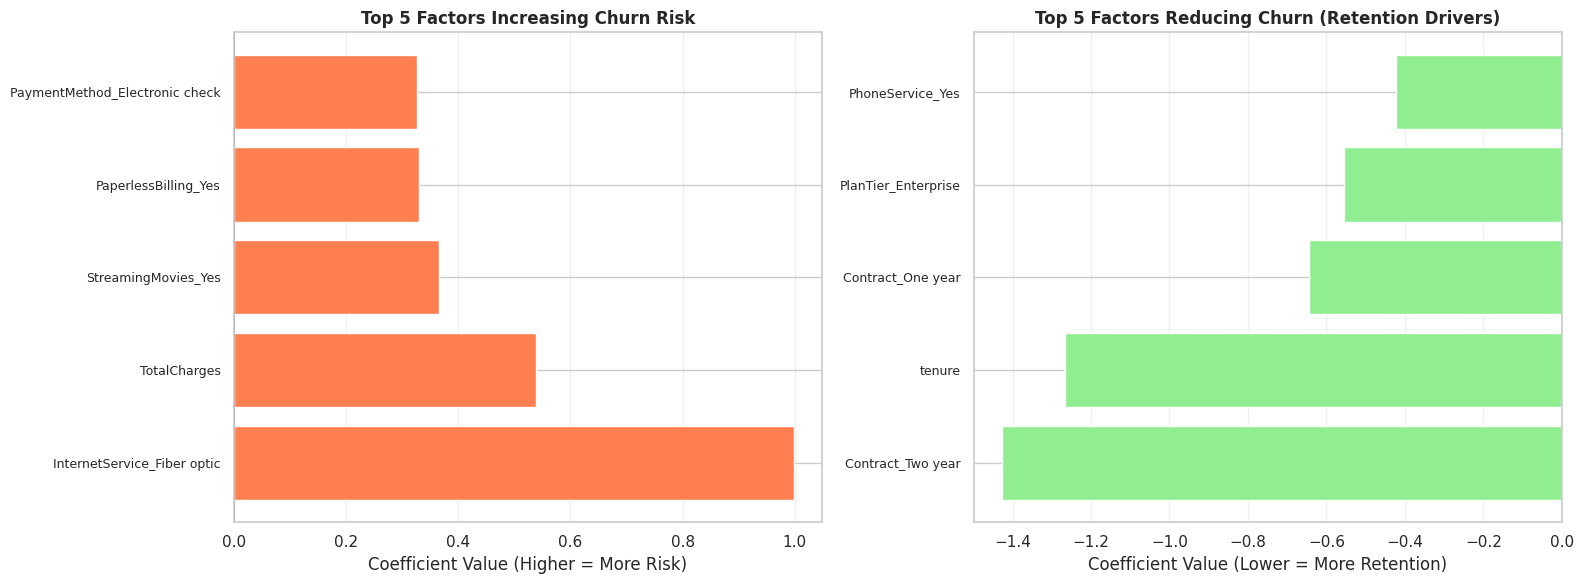

=== AUTOMATED INSIGHTS: TOP 3 RISK FACTORS ===

1. HIGH-RISK SEGMENT: High Monthly Charges + Month-to-Month Contract
   - Customers: 870 (12.4% of total)
   - Churn Rate: 52.2%
   - Action: Offer contract incentives or payment plans

2. HIGH-RISK SEGMENT: New Customers (<12 months) with Fiber Optic
   - Customers: 880 (12.5% of total)
   - Churn Rate: 70.3%
   - Action: Early engagement programs, onboarding support

3. HIGH-RISK SEGMENT: Electronic Check + Paperless Billing
   - Customers: 1742 (24.7% of total)
   - Churn Rate: 49.8%
   - Action: Promote automatic payment methods, offer discounts

4. POTENTIAL RISK: Low Usage Customers (Charges < 50% of Monthly Rate)
   - Customers: 4 (0.1% of total)
   - Churn Rate: 75.0%
   - Action: Re-engagement campaigns, feature adoption programs


=== MODEL COEFFICIENTS SUMMARY ===

Top 3 Factors Increasing Churn Risk:
  - InternetService_Fiber optic: 0.9983
  - TotalCharges: 0.5389
  - StreamingMovies_Yes: 0.3663

Top 3 Factors Reducing Churn (

In [9]:
# Extract Model Coefficients
coeffs = pd.DataFrame({
    'Feature': X.columns,
    'Importance': log_reg.coef_[0]
})
coeffs['AbsImportance'] = coeffs['Importance'].abs()
coeffs = coeffs.sort_values(by='AbsImportance', ascending=False)

# Top Risk Factors
top_risk_factors = coeffs.sort_values(by='Importance', ascending=False).head(5)
top_retention_factors = coeffs.sort_values(by='Importance', ascending=True).head(5)

# Visualize Feature Importance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top Risk Factors
axes[0].barh(range(len(top_risk_factors)), top_risk_factors['Importance'].values, color='coral')
axes[0].set_yticks(range(len(top_risk_factors)))
axes[0].set_yticklabels(top_risk_factors['Feature'].values, fontsize=9)
axes[0].set_xlabel('Coefficient Value (Higher = More Risk)')
axes[0].set_title('Top 5 Factors Increasing Churn Risk', fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)
axes[0].axvline(x=0, color='black', linestyle='-', linewidth=0.5)

# Top Retention Factors
axes[1].barh(range(len(top_retention_factors)), top_retention_factors['Importance'].values, color='lightgreen')
axes[1].set_yticks(range(len(top_retention_factors)))
axes[1].set_yticklabels(top_retention_factors['Feature'].values, fontsize=9)
axes[1].set_xlabel('Coefficient Value (Lower = More Retention)')
axes[1].set_title('Top 5 Factors Reducing Churn (Retention Drivers)', fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
axes[1].axvline(x=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

# Automated Risk Factor Identification
print("=== AUTOMATED INSIGHTS: TOP 3 RISK FACTORS ===\n")

# Factor 1: High Monthly Charges + Month-to-Month Contract
high_charge_mtm = data[(data['MonthlyCharges'] > data['MonthlyCharges'].quantile(0.75)) &
                        (data['Contract'] == 'Month-to-month')]
if len(high_charge_mtm) > 0:
    risk1_churn_rate = (high_charge_mtm['ChurnBinary'].sum() / len(high_charge_mtm)) * 100
    print(f"1. HIGH-RISK SEGMENT: High Monthly Charges + Month-to-Month Contract")
    print(f"   - Customers: {len(high_charge_mtm)} ({len(high_charge_mtm)/len(data)*100:.1f}% of total)")
    print(f"   - Churn Rate: {risk1_churn_rate:.1f}%")
    print(f"   - Action: Offer contract incentives or payment plans\n")

# Factor 2: Low Tenure + Fiber Optic
low_tenure_fiber = data[(data['tenure'] < 12) & (data['InternetService'] == 'Fiber optic')]
if len(low_tenure_fiber) > 0:
    risk2_churn_rate = (low_tenure_fiber['ChurnBinary'].sum() / len(low_tenure_fiber)) * 100
    print(f"2. HIGH-RISK SEGMENT: New Customers (<12 months) with Fiber Optic")
    print(f"   - Customers: {len(low_tenure_fiber)} ({len(low_tenure_fiber)/len(data)*100:.1f}% of total)")
    print(f"   - Churn Rate: {risk2_churn_rate:.1f}%")
    print(f"   - Action: Early engagement programs, onboarding support\n")

# Factor 3: Electronic Check Payment + Paperless Billing
electronic_paperless = data[(data['PaymentMethod'] == 'Electronic check') &
                            (data['PaperlessBilling'] == 'Yes')]
if len(electronic_paperless) > 0:
    risk3_churn_rate = (electronic_paperless['ChurnBinary'].sum() / len(electronic_paperless)) * 100
    print(f"3. HIGH-RISK SEGMENT: Electronic Check + Paperless Billing")
    print(f"   - Customers: {len(electronic_paperless)} ({len(electronic_paperless)/len(data)*100:.1f}% of total)")
    print(f"   - Churn Rate: {risk3_churn_rate:.1f}%")
    print(f"   - Action: Promote automatic payment methods, offer discounts\n")

# Additional: Inactive Users (Low Total Charges relative to Tenure)
data['ChargesPerMonth'] = data['TotalCharges'] / (data['tenure'] + 1)  # +1 to avoid division by zero
low_usage = data[data['ChargesPerMonth'] < data['MonthlyCharges'] * 0.5]  # Using less than 50% of expected
if len(low_usage) > 0:
    risk4_churn_rate = (low_usage['ChurnBinary'].sum() / len(low_usage)) * 100
    print(f"4. POTENTIAL RISK: Low Usage Customers (Charges < 50% of Monthly Rate)")
    print(f"   - Customers: {len(low_usage)} ({len(low_usage)/len(data)*100:.1f}% of total)")
    print(f"   - Churn Rate: {risk4_churn_rate:.1f}%")
    print(f"   - Action: Re-engagement campaigns, feature adoption programs\n")

# Summary Table
print("\n=== MODEL COEFFICIENTS SUMMARY ===")
print("\nTop 3 Factors Increasing Churn Risk:")
for idx, row in top_risk_factors.head(3).iterrows():
    print(f"  - {row['Feature']}: {row['Importance']:.4f}")

print("\nTop 3 Factors Reducing Churn (Retention Drivers):")
for idx, row in top_retention_factors.head(3).iterrows():
    print(f"  - {row['Feature']}: {row['Importance']:.4f}")

# High-Risk Customer Summary
high_risk = data[data['ChurnRiskScore'] > 0.7]
print(f"\n=== HIGH-RISK CUSTOMER SUMMARY ===")
print(f"Total High-Risk Customers (Risk Score > 0.7): {len(high_risk)}")
if len(high_risk) > 0:
    print(f"Average Monthly Revenue at Risk: ${high_risk['MonthlyCharges'].sum():,.2f}")
    print(f"Recommended Action: Proactive retention offers for {len(high_risk)} customers")

In [10]:
# Final Summary Dashboard
print("=" * 60)
print("CUSTOMER CHURN ANALYTICS - EXECUTIVE SUMMARY")
print("=" * 60)

print(f"\n📊 KEY PERFORMANCE INDICATORS:")
print(f"   • Churn Rate: {churn_rate:.2f}%")
print(f"   • ARPU: ${arpu:.2f}")
print(f"   • Average CLV: ${simple_clv:.2f}")
print(f"   • Revenue at Risk: {revenue_at_risk_pct:.2f}%")

print(f"\n🎯 PREDICTIVE MODEL:")
print(f"   • Model Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"   • High-Risk Customers Identified: {len(data[data['ChurnRiskScore'] > 0.7])}")
print(f"   • Potential Revenue Saved: ${data[data['ChurnRiskScore'] > 0.7]['MonthlyCharges'].sum():,.2f}/month")

print(f"\n💡 KEY INSIGHTS:")
print(f"   1. {top_risk_factors.iloc[0]['Feature']} is the strongest churn driver")
print(f"   2. {top_retention_factors.iloc[0]['Feature']} is the strongest retention driver")
print(f"   3. Plan Tier with highest churn: {data.groupby('PlanTier')['ChurnBinary'].mean().idxmax()}")
print(f"   4. Contract type with lowest churn: {data.groupby('Contract')['ChurnBinary'].mean().idxmin()}")

print(f"\n🚀 RECOMMENDED ACTIONS:")
print(f"   1. Target high-risk customers (Risk Score > 0.7) with retention offers")
print(f"   2. Promote long-term contracts to reduce churn")
print(f"   3. Improve onboarding for new Fiber Optic customers")
print(f"   4. Encourage automatic payment methods over Electronic Check")

print("\n" + "=" * 60)

CUSTOMER CHURN ANALYTICS - EXECUTIVE SUMMARY

📊 KEY PERFORMANCE INDICATORS:
   • Churn Rate: 26.54%
   • ARPU: $64.76
   • Average CLV: $2096.41
   • Revenue at Risk: 30.50%

🎯 PREDICTIVE MODEL:
   • Model Accuracy: 0.8233
   • High-Risk Customers Identified: 427
   • Potential Revenue Saved: $36,062.10/month

💡 KEY INSIGHTS:
   1. InternetService_Fiber optic is the strongest churn driver
   2. Contract_Two year is the strongest retention driver
   3. Plan Tier with highest churn: Enterprise
   4. Contract type with lowest churn: Two year

🚀 RECOMMENDED ACTIONS:
   1. Target high-risk customers (Risk Score > 0.7) with retention offers
   2. Promote long-term contracts to reduce churn
   3. Improve onboarding for new Fiber Optic customers
   4. Encourage automatic payment methods over Electronic Check

